# Introduction

This notebook is intended to extract useful insights for the datasets of ‘Tabular Playground Series - Mar 2021’ competition in Kaggle. For this competition, it is required to tackle the Classification problem to predict a continuous target based on a number of feature columns given in the data. All of the feature columns, cat0 - cat9 are categorical, and the feature columns cont0 - cont13 are continuous.

We are going to do the feature importance detection for raw features only, using Featurewiz (https://github.com/AutoViML/featurewiz)



In [1]:
#!pip install featurewiz

# Initial Preparations

We are going to start with the essential pre-requisites as follows

- installing *featurewiz* into this notebook
- importing the standard Python packages we need to use down the road
- programming the useful automation routines for repeatable data visualizations we are going to draw in the Advance Analytical EDA trials down the road

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from typing import Tuple, List, Dict

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from featurewiz import FE_kmeans_resampler, FE_find_and_cap_outliers, EDA_find_outliers
from featurewiz import FE_convert_all_object_columns_to_numeric, split_data_n_ways, FE_create_categorical_feature_crosses
from featurewiz import FE_create_time_series_features, FE_concatenate_multiple_columns
from featurewiz import simple_XGBoost_model
import featurewiz as FW


# read data
in_kaggle = False

def get_data_file_path(is_in_kaggle: bool) -> Tuple[str, str, str]:
    train_path = ''
    test_path = ''
    sample_submission_path = ''

    if is_in_kaggle:
        # running in Kaggle, inside the competition
        train_path = '../input/tabular-playground-series-mar-2021/train.csv'
        test_path = '../input/tabular-playground-series-mar-2021/test.csv'
        sample_submission_path = '../input/tabular-playground-series-mar-2021/sample_submission.csv'
    else:
        # running locally
        train_path = 'data/train.csv'
        test_path = 'data/test.csv'
        sample_submission_path = 'data/sample_submission.csv'

    return train_path, test_path, sample_submission_path



C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Imported featurewiz: advanced feature engg and selection library. Version=0.0.33
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


In [3]:
# main flow
start_time = dt.datetime.now()
print("Started at ", start_time)

Started at  2021-04-19 23:21:10.963946


In [4]:
%%time
# get the training set and labels
train_set_path, test_set_path, sample_subm_path = get_data_file_path(in_kaggle)

train = pd.read_csv(train_set_path)
test = pd.read_csv(test_set_path)

subm = pd.read_csv(sample_subm_path)

Wall time: 2.66 s


# Basic Data Overview

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
 18  cat17   300000 non-null  object 
 19  cat18   300000 non-null  object 
 20  cont0   300000 non-null  float64
 21  cont1   30

# Additional Feature Engineering

In a series of feature importance experiments (with *AutoViz* engaged), we got the following insights regarding the feature engineering and data preprocessing pipelines

The following continual variables to be useful in feature importance experiment, to be left ‘as is’: cont1, cont3, cont5, cont6, and cont8

The rest of the continual variables to be binned as follows
- cont0: 4 
- cont1: 5 
- cont3: 2 
- cont4: 2 
- cont6: 3 
- cont8: 3 
- cont10: 10

New groupby features to be added
- groupby cont3 by cat2, cont1 by cat4, cont3 by cat4

New interaction cat variables (feature crosses) to be added
- cat4 x cat18
- cat13 x cat4
- cat13 x cat2

New interaction continual variables, then to be binned as follows
- cont3 x cont7 
- cont3 x cont8 
- cont3 x cont9 
- cont3 x cont10 
- cont4 x cont5 
- cont4 x cont6 
- cont4 x cont9 
- cont4 x cont10

Boolean cat variables to be used as is 
- cat0 
- cat1 
- cat12 
- cat13 
- cat14 
- cat15 
- cat16

Finally, we are going to apply log transform to cont5, cont8, and cont7

In [6]:
%%time
### Step 1: we create numeric interaction variables first ###
intxn_vars = [('cont3', 'cont7'),('cont3', 'cont8'),('cont3', 'cont9'),('cont3', 'cont10'),('cont4', 'cont5'),
             ('cont4', 'cont6'),('cont4', 'cont9'),('cont4', 'cont10')]
def FE_create_interaction_vars(df, intxn_vars):
    """
    This handy function creates interaction variables among pairs of numeric vars you send in.
    Your input must be a dataframe and a list of tuples. Each tuple must contain a pair of variables.
    All variables must be numeric. Double check your input before sending them in.
    """
    df = df.copy(deep=True)
    for (each_intxn1,each_intxn2)  in intxn_vars:
        new_col = each_intxn1 + '_x_' + each_intxn2
        try:
            df[new_col] = df[each_intxn1] * df[each_intxn2]
        except:
            continue
    return df

Wall time: 0 ns


In [7]:
%%time
train = FE_create_interaction_vars(train, intxn_vars)
test = FE_create_interaction_vars(test, intxn_vars)

Wall time: 113 ms


In [8]:
%%time
### step 2: we bin the following numeric variables using gaussian mixture models
bin_these = {'cont0': 4, 'cont1': 5, 'cont3': 2, 'cont4': 2, 'cont6': 3, 'cont8': 3, 'cont10': 10}
train, test = FW.FE_discretize_numeric_variables(train,bin_these,test=test, strategy='gaussian')

Wall time: 9.7 s


In [9]:
%%time
### step 3: next we create feature crosses of these categorical variables ###
train = FW.FE_create_categorical_feature_crosses(train, ['cat4','cat18','cat13','cat2'])
test = FW.FE_create_categorical_feature_crosses(test, ['cat4','cat18','cat13','cat2'])

Wall time: 3.01 s


In [10]:
%%time
### step 4: create groupby aggregates of the following numerics 
agg_nums = ['cont1','cont3']
groupby_vars = ['cat2','cat4']
train_add, test_add = FW.FE_add_groupby_features_aggregated_to_dataframe(train[agg_nums+groupby_vars], 
                                agg_types=['mean','std'],
                                groupby_columns=groupby_vars,
                                ignore_variables=[] , test=test[agg_nums+groupby_vars])

4 new columns created for numeric data grouped by ['cat2'] for aggregates ['mean', 'std']
4 new columns created for numeric data grouped by ['cat4'] for aggregates ['mean', 'std']
Wall time: 814 ms


In [11]:
%%time
train_copy = train.join(train_add.drop(groupby_vars+agg_nums, axis=1))
test_copy = test.join(test_add.drop(groupby_vars+agg_nums, axis=1))
print(train_copy.shape, test_copy.shape)
train_copy.head(2)

(300000, 61) (200000, 60)
Wall time: 247 ms


In [12]:
%%time
###### step 5: log transform these columns ##########
log_cols = {'cont5':'log', 'cont8':'log', 'cont7':'log'}
train_copy = FW.FE_transform_numeric_columns(train_copy, log_cols)
test_copy = FW.FE_transform_numeric_columns(test_copy, log_cols)
train_copy.head(2)

Wall time: 683 ms


In [13]:
#finally, drop 'id' col
train_copy = train_copy.drop(columns=['id'])
test_copy = test_copy.drop(columns=['id'])

# Feature Importance Study

We are going to invoke *featurewiz*, one of the prominent freeware Pythonic AutoML Feature Selection tools, to quickly identify the essential predictors after we completed the feature engineering above.

Skipping feature engineering since no feature_engg input...
Shape of your Data Set loaded: (300000, 63)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    62 Predictors classified...
        9 variable(s) removed since they were ID or low-information variables
Shape of your Data Set loaded: (300000, 63)
Shape of your Data Set loaded: (200000, 62)
Number of processors on machine = 1
    No GPU active on this device
    Running XGBoost using CPU parameters
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    62 Predictors classified...
        9 variable(s) removed since they were ID or low-information variables
#### Single_Label Binary_Classification Feature Selection Started ####
Starting feature engineering...this will take time...
Source X_train shape:  (300000, 53) | X_test shape:  (200000, 53)
##################################################
> Star

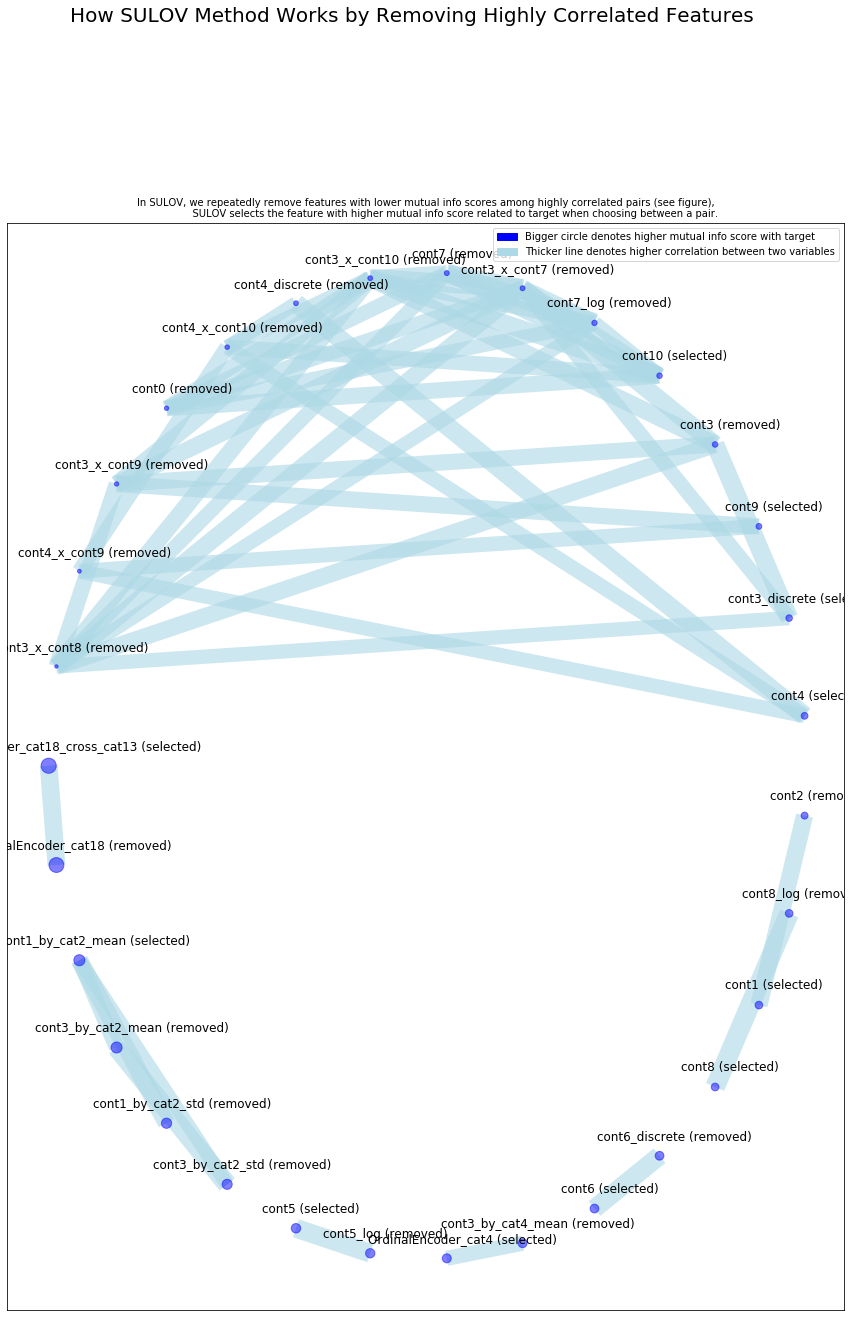

    Adding 0 categorical variables to reduced numeric variables  of 33
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 33 
    Finding Important Features using Boosted Trees algorithm...
        using 33 variables...
        using 26 variables...
        using 19 variables...
        using 12 variables...
        using 5 variables...
Selected 14 important features from your dataset
    Time taken (in seconds) = 458
Returning 2 dataframes: train and test with 14 important features.


In [14]:
from featurewiz import featurewiz

# out1 and out2: is always a tuple containing two objects. 
# In our case, it is going to be "test" and "train" dataframes with the important features selected by featurewiz
trainm, testm = FW.featurewiz(
    train_copy, 
    target='target', 
    corr_limit=0.7, 
    verbose=2, 
    sep=",",
    header=0,
    test_data=test_copy,     
    feature_engg="", # we do not want featurewiz to create any additional features in this experiment
    category_encoders="OrdinalEncoder" #OrdinalEncoder
)

In [15]:
# check the important features detected by featurewiz
display(trainm.columns)

Index(['OrdinalEncoder_cat16', 'OrdinalEncoder_cat15', 'OrdinalEncoder_cat0',
       'OrdinalEncoder_cat18_cross_cat13', 'OrdinalEncoder_cat14',
       'OrdinalEncoder_cat11', 'OrdinalEncoder_cat2', 'cont3_discrete',
       'cont1_by_cat2_mean', 'cont5', 'cont1', 'cont4', 'cont9', 'cont10',
       'target'],
      dtype='object')

In [16]:
print('We are done. That is all, folks!')
finish_time = dt.datetime.now()
print("Finished at ", finish_time)
elapsed = finish_time - start_time
print("Elapsed time: ", elapsed)

We are done. That is all, folks!
Finished at  2021-04-19 23:29:18.043585
Elapsed time:  0:08:07.079639


# Results of Experiments



# References

- [featurewiz repo](https://github.com/AutoViML/featurewiz)